## Step 1: Library import

In [19]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.model_selection import GridSearchCV

import xray_data #y data: 1 = NORMAL, 0 = PNEUMONIA

import random

random.seed(207)

## Step 2: Load and preprocess data
Note: data is resized and preprocessed as it is read, as a memory optimization.

In [2]:
#Constants
scale = 200
label_filter = ['NORMAL','PNEUMONIA','COVID19','TURBERCULOSIS']
subset = 'PROP' # either "EQL" or "PROP"

In [3]:
X_dev_orig, y_dev_orig = xray_data.load_val(scale,label_filter,subset=subset)
print(f'X_dev_orig, y_dev_orig shape: {X_dev_orig.shape, y_dev_orig.shape}')
print(f'y_dev_orig shape for NORMAL cases: {y_dev_orig[y_dev_orig ==1].shape}')
print('----')

100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (12 of 12) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


NORMAL: 8
COVID19: 10
PNEUMONIA: 8
TURBERCULOSIS: 12
Total: 38
X_dev_orig, y_dev_orig shape: ((38, 40000), (38,))
y_dev_orig shape for NORMAL cases: (8,)
----


In [4]:
# cut of for training samples of each class, only 230 normal rows
test_cutoff = 230

X_test, y_test = xray_data.load_test(scale,label_filter,test_cutoff,subset=subset)
print(f'X_test, y_test shape: {X_test.shape, y_test.shape}')
print(f'y_test shape for NORMAL cases: {y_test[y_test ==1].shape}')
print('----')

100% (234 of 234) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (106 of 106) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (390 of 390) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (41 of 41) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


NORMAL: 69
COVID19: 31
PNEUMONIA: 116
TURBERCULOSIS: 12
Total: 228
X_test, y_test shape: ((228, 40000), (228,))
y_test shape for NORMAL cases: (116,)
----


In [5]:
# cut of for training samples of each class, only 1300 normal rows

X_train, y_train = xray_data.load_train(scale,label_filter,subset=subset)


100% (1341 of 1341) |####################| Elapsed Time: 0:00:38 Time:  0:00:38
100% (460 of 460) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
100% (3875 of 3875) |####################| Elapsed Time: 0:00:41 Time:  0:00:41
100% (650 of 650) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


NORMAL: 1341
COVID19: 460
PNEUMONIA: 3875
TURBERCULOSIS: 650
Total: 6326


#### Step2a: Adjust all image sets by mean/std of train

In [6]:
#(mean,std) = xray_data.find_mean_std(X_train)
#print(mean,std)
#print(X_train.shape)
#adjusted_X_train = xray_data.normalize_images(X_train,mean,std)
#print (f'adjusted train {adjusted_X_train.shape}')
#adjusted_X_dev_org = xray_data.normalize_images(X_dev_orig,mean,std)
#adjusted_X_test = xray_data.normalize_images(X_test,mean,std)
# uncomment to use rescaled data
# X_train = adjusted_X_train
# X_dev_org = adjusted_X_dev_orig
# X_test = adjusted_X_test

### Step 2b: Split data into dev and train
Original dev data set is too small for much validity


In [7]:
# I'm not sure what the final stratify parameter is doing.  We'll want to revist when we do full cross validation

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = .2, stratify = y_train )
print(f'X_train, y_train shape: {X_train.shape, y_train.shape}')
print(f'y_train shape for NORMAL cases: {y_train[y_train ==1].shape}')
print('----')
print(f'X_dev, y_dev shape: {X_dev.shape, y_dev.shape}')
print(f'y_dev shape for NORMAL cases: {y_dev[y_dev ==1].shape}')

X_train, y_train shape: ((5060, 40000), (5060,))
y_train shape for NORMAL cases: (3099,)
----
X_dev, y_dev shape: ((1266, 40000), (1266,))
y_dev shape for NORMAL cases: (776,)


## Step 3: Single Model training

Default values:  The default model for SVC is 
 - C=1, 
 - kernel='rbf', 
 - gamma=1/(n_features * X.var()).  For a 200x200 rescale this results in gamma = .000025/X.var().  We may want to go with smaller gamma values.



In [8]:

base_model = svm.SVC()

base_model.fit(X_train,y_train)
y_pred = base_model.predict(X_dev)
print(f'Single Model accuracy: {accuracy_score(y_pred,y_dev)*100:9.5}')

Single Model accuracy:    95.577


## Step 4  CrossValidated Gridsearch models

In [ ]:

param_grid={'C': [0.1, 1, 10, 100],
            'gamma': [0.0001, 0.001, 0.1, 1],
            'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}
svc = svm.SVC()
CV_model = GridSearchCV(svc,param_grid,verbose=3)

CV_model.fit(X_train,y_train)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.833 total time= 3.8min
[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.834 total time= 3.9min
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.838 total time= 4.0min
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.839 total time=12.8min
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.826 total time=17.7min
[CV 1/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.858 total time=11.2min
[CV 2/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.847 total time=18.4min
[CV 3/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.856 total time=10.5min
[CV 4/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.857 total time=10.7min
[CV 5/5] END ..C=0.1, gamma=0.0001, kernel=poly;, score=0.842 total time=11.4min
[CV 1/5] END C=0.1, gamma=0.0001, kernel=linear;, score=0.942 total time= 8.2min
[CV 2/5] END C=0.1, gamma=0.0001, kernel=linear

[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.951 total time= 2.1min
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.943 total time= 2.1min
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.956 total time= 2.1min
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.958 total time= 2.1min
[CV 1/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.938 total time=  56.2s
[CV 2/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.942 total time=  56.5s
[CV 3/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.932 total time=  56.4s
[CV 4/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.951 total time=  56.7s
[CV 5/5] END .....C=1, gamma=0.001, kernel=poly;, score=0.943 total time=  56.8s
[CV 1/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.942 total time= 1.0min
[CV 2/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.938 total time= 1.1min
[CV 3/5] END ...C=1, gamma=0.001, kernel=linear;, score=0.931 total time= 1.0min
[CV 4/5] END ...C=1, gamma=0

[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.618 total time= 8.4min
[CV 5/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.620 total time= 8.4min
[CV 1/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.938 total time=  55.9s
[CV 2/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.942 total time=  56.4s
[CV 3/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.932 total time=  56.3s
[CV 4/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.951 total time=  56.2s
[CV 5/5] END ......C=10, gamma=0.1, kernel=poly;, score=0.943 total time=  56.6s
[CV 1/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.942 total time= 1.0min
[CV 2/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.938 total time= 1.0min
[CV 3/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.931 total time= 1.0min
[CV 4/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.936 total time= 1.0min
[CV 5/5] END ....C=10, gamma=0.1, kernel=linear;, score=0.936 total time= 1.1min
[CV 1/5] END ...C=10, gamma=

In [14]:
print(f'Best score: {CV_model.best_score_*100:9.5}')
print(f'Best params: {CV_model.best_params_}')

Best score:    95.593
Best params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [17]:
y_pred = CV_model.predict(X_dev)
print(f'Best Fit Model accuracy: {f1_score(y_pred,y_dev,average="weighted")*100:9.5}')

Best Fit Model accuracy:    96.865


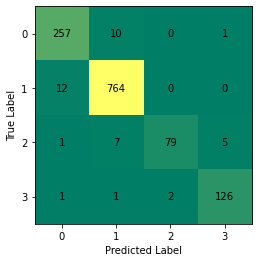

In [24]:
grid= confusion_matrix(y_dev,y_pred)
plt.imshow(grid, cmap = 'summer')

for (j,i),label in np.ndenumerate(grid):
    plt.text(i,j,label,ha='center',va='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0,1,2,3]);
plt.yticks([0,1,2,3]);